In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from tqdm import tqdm
import math
from random import sample 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import warnings
import ast
import random
import numpy as np
import pickle
warnings.filterwarnings("ignore")

import ast
ast.literal_eval

import sys
sys.path.append('./models/')
import pernir_metrics
import pretty_plotter
import pernir_user_imitation

### 1. Instacart

In [4]:
train_baskets = pd.read_csv('../data/instacart/train_baskets.csv')
test_samples = pd.read_csv('../data/instacart/test_sample_to_predict_instacart.csv')

In [27]:
#sampling baskest of 100 users with the amount of masked items > 1
ts = test_samples[test_samples.num_to_mask > 1][
    ['basket_id', 'user_id', 'full_basket', 'num_to_mask']].sample(5000)

In [28]:
model = pernir_user_imitation.Collab(train_baskets, ts, train_url = '../data/instacart/user_sim.pickle')
print('train...')
model.train()

train...


In [29]:
def generate_masked_baskets(row):
    basket = eval(row['full_basket'])
    num_to_mask = row['num_to_mask']
    
    masked_baskets = []
    for num_items_to_mask in range(1, num_to_mask + 1):
        masked_indices = random.sample(range(len(basket)), num_items_to_mask)
        
        masked_basket = [item for idx, item in enumerate(basket) if idx not in masked_indices]
        masked_baskets.append(masked_basket)
    
    # adding actual_masked_num to indicate how many items were masked
    masked_baskets_with_info = []
    for i, masked_basket in enumerate(masked_baskets):
        masked_baskets_with_info.append({
            'masked_basket': masked_basket,
            'actual_masked_num': i + 1 
        })
    
    return masked_baskets_with_info

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])


In [30]:
#cool 
assert len(ts.loc[0].masked_basket) == len(eval(ts.loc[0].full_basket)) - ts.loc[0].actual_masked_num

In [31]:
#now we have all the masked basket states as seperate basket to compute predictions for 
print(ts.shape)
ts.head()

(15209, 6)


,basket_id,user_id,full_basket,num_to_mask,masked_basket,actual_masked_num
0,611167,54222,"[45578, 46802, 9390, 24489, 1158, 8193, 35108,...",3,"[45578, 46802, 9390, 24489, 1158, 8193, 35108,...",1
1,611167,54222,"[45578, 46802, 9390, 24489, 1158, 8193, 35108,...",3,"[45578, 46802, 9390, 24489, 1158, 35108, 42244...",2
2,611167,54222,"[45578, 46802, 9390, 24489, 1158, 8193, 35108,...",3,"[45578, 46802, 9390, 24489, 1158, 8193, 42244,...",3
3,1740512,127266,"[9405, 12572, 38944, 2164, 2326, 13838, 8021, ...",8,"[9405, 12572, 38944, 2326, 13838, 8021, 19173,...",1
4,1740512,127266,"[9405, 12572, 38944, 2164, 2326, 13838, 8021, ...",8,"[9405, 12572, 38944, 2164, 2326, 13838, 8021, ...",2


In [32]:
def get_predictions(row, model, previously_predicted):
    user_id = row['user_id']
    basket_id = row['basket_id']
    masked_basket = row['masked_basket']

    # get previously predicted items for the current user and basket
    prev_items = previously_predicted.get((user_id, basket_id), set())

    # generate new predictions
    predictions = model.predict(user_id, masked_basket, prev_items)

    # update previously predicted items to exclude from next basket recommendations
    previously_predicted[(user_id, basket_id)] = prev_items.union(predictions)

    return predictions


ts_sorted = ts.sort_values(by=['user_id', 'basket_id', 'actual_masked_num'], ascending=[True, True, False])
previously_predicted = {}

ts_sorted['pred'] = ts_sorted.apply(lambda row: get_predictions(row, model, previously_predicted), axis=1)

In [40]:
ts_sorted.head(5)

,basket_id,user_id,full_basket,num_to_mask,masked_basket,actual_masked_num,pred,precision@1,recall@1,precision@2,...,ndcg@11,ndcg@12,ndcg@13,ndcg@14,ndcg@15,ndcg@16,ndcg@17,ndcg@18,ndcg@19,ndcg@20
14269,227361,53,"[12583, 17757, 12193, 32465, 32864, 25207, 900...",2,"[12583, 17757, 12193, 32864, 25207, 9000, 3979...",2,"[24339, 36780, 15804, 13245, 37609, 11210, 861...",0.923077,0.857143,0.857143,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
14268,227361,53,"[12583, 17757, 12193, 32465, 32864, 25207, 900...",2,"[12583, 17757, 12193, 32465, 32864, 25207, 397...",1,"[32864, 38063, 16939, 12232, 6052, 17313, 4873...",1.000000,0.928571,0.928571,...,1.0,1.0,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000
4268,1456703,54,"[40174, 42736, 18531, 23452, 43789, 2314, 1191...",2,"[40174, 42736, 18531, 23452, 43789, 2314, 1191...",2,"[6638, 12023, 24852, 38231, 26165, 39180, 2496...",0.923077,0.857143,0.857143,...,0.0,0.0,0.0,0.0,0.25,0.250000,0.250000,0.250000,0.250000,0.250000
4267,1456703,54,"[40174, 42736, 18531, 23452, 43789, 2314, 1191...",2,"[40174, 42736, 18531, 23452, 43789, 2314, 1191...",1,"[35221, 47626, 41488, 12107, 21616, 20842, 424...",0.928571,0.928571,0.866667,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
14548,355095,106,"[33452, 40287, 43352, 16797, 25272, 41625, 371...",3,"[40287, 43352, 16797, 25272, 41625, 37131, 248...",3,"[6265, 36552, 6204, 39188, 10990, 36259, 35534...",0.941176,0.842105,0.888889,...,0.0,0.0,0.0,0.0,0.25,0.303294,0.344668,0.344668,0.344668,0.344668


In [41]:
#cool cool cool
set(ts_sorted.loc[0].masked_basket) & set(ts_sorted.loc[0].pred)

set()

In [42]:
ts_sorted.masked_basket = ts_sorted.masked_basket.apply(lambda x: str(x))
ts_sorted.full_basket = ts_sorted.full_basket.apply(lambda x: str(x))

In [43]:
pernir_metrics.calculate_and_save_precision_recall(ts_sorted)

In [44]:
pernir_metrics.calculate_and_save_ndcg(ts_sorted)

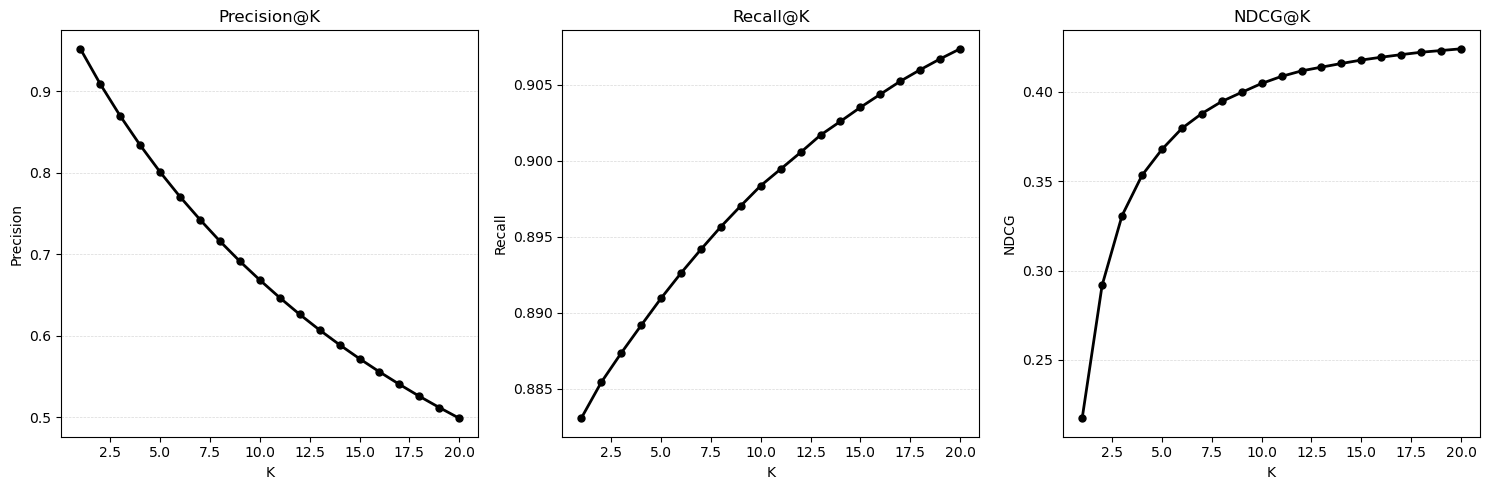

In [45]:
pretty_plotter.plot_pretty_metrics_pernir(ts_sorted)

In [46]:
ts_sorted.describe().loc[:, ts_sorted.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,15209.000000,15209.000000,15209.000000
mean,0.668336,0.898345,0.404588
std,0.107027,0.047342,0.358931
min,0.444444,0.800000,0.000000
25%,0.588235,0.866667,0.000000
50%,0.666667,0.903226,0.411834
75%,0.740741,0.933333,0.700912
max,1.000000,1.000000,1.000000


## 2. Ta Feng

In [47]:
train_baskets = pd.read_csv('../data/ta_feng/train_baskets.csv').drop('index', axis = 1)
test_samples = pd.read_csv('../data/ta_feng/test_sample_to_predict_ta_feng.csv')

In [48]:
ts = test_samples[['basket_id', 'user_id', 'full_basket', 'num_to_mask']].sample(5000)

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [50]:
model = pernir_user_imitation.Collab(train_baskets, ts, train_url = '../data/ta_feng/user_sim.pickle')
print('train...')
model.train()
print('predict...')

train...
predict...


In [51]:
ts_sorted = ts.sort_values(by=['user_id', 'basket_id', 'actual_masked_num'], ascending=[True, True, False])
previously_predicted = {}

ts_sorted['pred'] = ts_sorted.apply(lambda row: get_predictions(row, model, previously_predicted), axis=1)

In [53]:
# there are baskets with 0 predictions
ts_sorted = ts_sorted[ts_sorted.pred.apply(lambda x: len(x)) > 0]

In [54]:
ts_sorted.masked_basket = ts_sorted.masked_basket.apply(lambda x: str(x))
ts_sorted.full_basket = ts_sorted.full_basket.apply(lambda x: str(x))

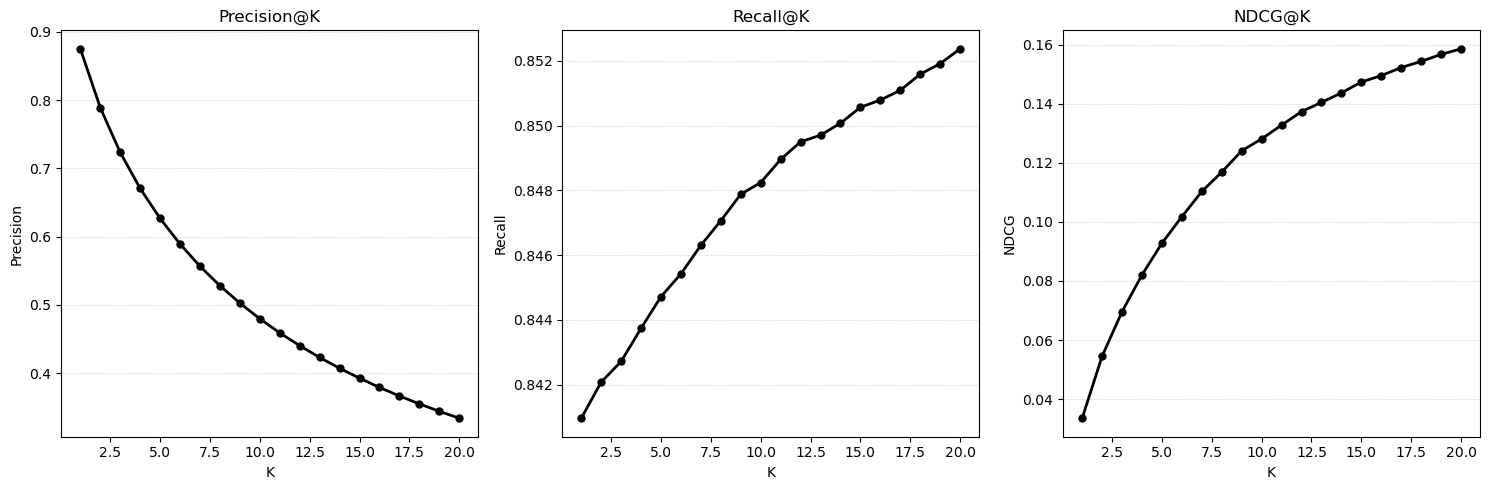

In [55]:
pernir_metrics.calculate_and_save_precision_recall(ts_sorted)
pernir_metrics.calculate_and_save_ndcg(ts_sorted)
pretty_plotter.plot_pretty_metrics_pernir(ts_sorted)

In [56]:
ts_sorted.describe().loc[:, ts_sorted.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,5193.000000,5193.000000,5193.000000
mean,0.479535,0.848241,0.128100
std,0.181876,0.081803,0.238732
min,0.166667,0.666667,0.000000
25%,0.333333,0.800000,0.000000
50%,0.500000,0.857143,0.000000
75%,0.615385,0.909091,0.289065
max,1.000000,1.000000,1.000000


## 3. Dunnhubpy

In [57]:
train_baskets = pd.read_csv('../data/dunnhumby/train_baskets.csv').drop('index', axis = 1)
test_samples = pd.read_csv('../data/dunnhumby/test_sample_to_predict_dunnhumby.csv')

In [61]:
#using all sampled users
ts = test_samples[['basket_id', 'user_id', 'full_basket', 'num_to_mask']]

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [63]:
model = pernir_user_imitation.Collab(train_baskets,ts, train_url = '../data/dunnhumby/user_sim.pickle')
print('train...')
model.train()
print('predict...')

train...
predict...


In [65]:
ts_sorted = ts.sort_values(by=['user_id', 'basket_id', 'actual_masked_num'], ascending=[True, True, False])
previously_predicted = {}

ts_sorted['pred'] = ts_sorted.apply(lambda row: get_predictions(row, model, previously_predicted), axis=1)

In [66]:
# there are baskets with 0 predictions
ts_sorted = ts_sorted[ts_sorted.pred.apply(lambda x: len(x)) > 0]

ts_sorted.masked_basket = ts_sorted.masked_basket.apply(lambda x: str(x))
ts_sorted.full_basket = ts_sorted.full_basket.apply(lambda x: str(x))

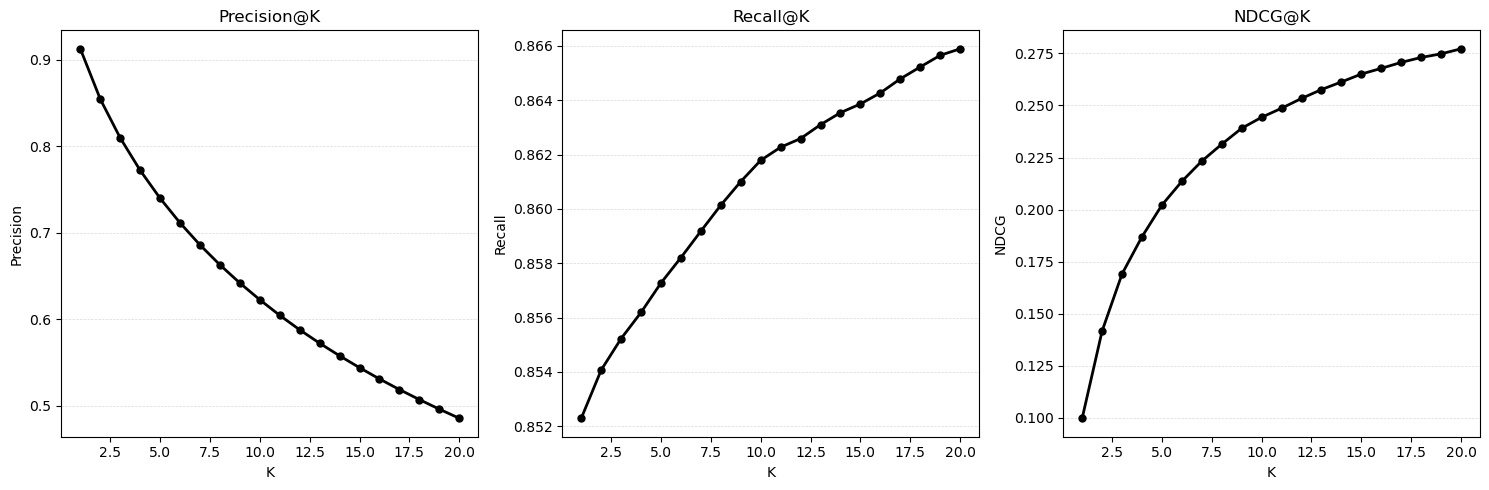

In [67]:
pernir_metrics.calculate_and_save_precision_recall(ts_sorted)
pernir_metrics.calculate_and_save_ndcg(ts_sorted)
pretty_plotter.plot_pretty_metrics_pernir(ts_sorted)

In [68]:
ts_sorted.describe().loc[:, ts_sorted.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,6294.000000,6294.000000,6294.000000
mean,0.622595,0.861787,0.244313
std,0.227659,0.104618,0.314633
min,0.090909,0.500000,0.000000
25%,0.500000,0.833333,0.000000
50%,0.692308,0.876712,0.000000
75%,0.803922,0.928571,0.430677
max,0.985915,1.000000,1.000000
